In [1]:
#!pip3 install cython

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
!ls

A_Profiling.ipynb                     README.md
B_Cython.ipynb                        setup.py
C_Advanced_Cython.ipynb               wave_propogation.cpython-38-darwin.so
D_Using_Fortran.ipynb                 wave_propogation.f90


### Fortran File
```Fortran
SUBROUTINE wave_propogation_fortran(num_steps, scale, damping, initial_P, stop_step, P)
  ! INPUTS
  ! num_steps -> int # Number of itereations to make
  ! scale -> int # Size of box for wave to propogate in
  ! damping -> float # Factor for damping wave
  ! initial_P -> float # Initial height at center
  ! stop_step -> int # Number of steps to stop wave
  ! OUTPUTS:
  ! P -> float(x,y) # Array of output heights
  IMPLICIT NONE
  INTEGER size_x,i,j,k,step
  REAL PI, omega
  INTEGER, INTENT(in)  :: num_steps, scale, stop_step !input
  REAL, INTENT(in) :: damping, initial_P !input
  REAL, INTENT(out) :: P(2 * scale + 1,2 * scale + 1) ! output
  REAL, DIMENSION(2 * scale + 1,2 * scale + 1,4) :: V

  size_x = 2 * scale + 1

  PI = 3.14159
  omega = 3.0 / (2.0 * PI)

! Setup initial matrix all 0's
! P is pressure matrix
! V is velocity tensor (matrix of x/y and 4 vector of velocity [up,down,left,right])
  DO k=1,4
     DO j=1,size_x
        DO i=1,size_x
           P(i,j) = 0.0
           V(i,j,k) = 0.0
        END DO
     END DO
  END DO

  ! Set initial start height
  P(scale + 1,scale + 1) = initial_P

  ! For each step
  DO step = 1, num_steps
    ! If step is less than stopping step then add forcing function
    IF(step <= stop_step) THEN
      P(scale + 1 ,scale + 1) = initial_P * SIN(omega * step)
    ENDIF

    ! For each cell in matrix P
    DO j=1,size_x
      DO i=1,size_x
        IF (i == 0) THEN
          CYCLE
        END IF
        ! Calculate veolocity of wave at the points
        V(i,j,1) = MERGE(V(i,j,1) + P(i,j) - P(i - 1,j), P(i,j), i > 1)
        V(i,j,2) = MERGE(V(i,j,2) + P(i,j) - P(i,j + 1), P(i,j), j < size_x - 1)
        V(i,j,3) = MERGE(V(i,j,3) + P(i,j) - P(i + 1,j), P(i,j), i < size_x - 1)
        V(i,j,4) = MERGE(V(i,j,4) + P(i,j) - P(i,j - 1), P(i,j), j > 1)
      END DO
    END DO

    DO j=1,size_x
      DO i=1,size_x
        ! Get new pressure from P = P_0 - damping*V
        P(i,j) = P(i,j) - 0.5 * damping * (V(i,j,1) + V(i,j,2) + V(i,j,3) + V(i,j,4))
      END DO
    END DO
  END DO

END SUBROUTINE wave_propogation
```

### setup.py

```python
import numpy
from numpy.distutils.core import Extension
from numpy.distutils.core import setup


fortranExt = Extension(name="wave_propogation", sources=["wave_propogation.f90"])


setup(
    name="wave_propogation",
    description="Fortran library to compute wave propogation in a box",
    ext_modules=[fortranExt],
)
```

In [4]:
!python setup.py build_ext --inplace

running build_ext
running build_src
build_src
building extension "wave_propogation" sources
f2py options: []
f2py:> build/src.macosx-10.15-x86_64-3.8/wave_propogationmodule.c
creating build
creating build/src.macosx-10.15-x86_64-3.8
Reading fortran codes...
	Reading file 'wave_propogation.f90' (format:free)
Post-processing...
	Block: wave_propogation
			Block: wave_propogation_fortran
Post-processing (stage 2)...
Building modules...
	Building module "wave_propogation"...
		Constructing wrapper function "wave_propogation_fortran"...
		  p = wave_propogation_fortran(num_steps,scale,damping,initial_p,stop_step)
	Wrote C/API module "wave_propogation" to file "build/src.macosx-10.15-x86_64-3.8/wave_propogationmodule.c"
  adding 'build/src.macosx-10.15-x86_64-3.8/build/src.macosx-10.15-x86_64-3.8/fortranobject.c' to sources.
  adding 'build/src.macosx-10.15-x86_64-3.8/build/src.macosx-10.15-x86_64-3.8' to include_dirs.
creating build/src.macosx-10.15-x86_64-3.8/build
creating build/src.macos

In [5]:
import wave_propogation as wp

In [6]:
print(wp.wave_propogation_fortran.__doc__)

p = wave_propogation_fortran(num_steps,scale,damping,initial_p,stop_step)

Wrapper for ``wave_propogation_fortran``.

Parameters
----------
num_steps : input int
scale : input int
damping : input float
initial_p : input float
stop_step : input int

Returns
-------
p : rank-2 array('f') with bounds (2 * scale + 1,2 * scale + 1)



In [7]:
num_steps = 50
scale = 50
damping= 0.25
initial_p = 1
stop_step = 25

CPU times: user 1.62 ms, sys: 33 µs, total: 1.66 ms
Wall time: 1.66 ms


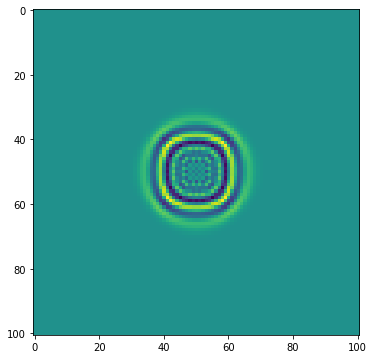

In [8]:
%time final_p = wp.wave_propogation_fortran(num_steps, scale, damping, initial_p, stop_step)
plt.figure(figsize=(12,6))
plt.imshow(final_p)
plt.show()